In [125]:
import numpy as np
from time import time
import csv
import json
from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
import nltk
import codecs
import pandas as pd
from IPython.display import display, HTML

In [126]:
data = pd.read_csv("./data/processed/final_dataset.csv",encoding="utf-8")
print(data.dtypes)
print(data.shape)

Unnamed: 0         int64
attitude          object
hashtags          object
id                 int64
processed_text    object
raw_text          object
seed_topic        object
topic             object
dtype: object
(123457, 8)


# Create for Each Topic a Single Classification
Train and Test each topic on its own with a 10-Fold Cross Validation

In [127]:
originalclass = []
predictedclass = []

own_classifier_results = []

def classification_report_with_accuracy_score(y_true, y_pred):
    global originalclass
    global predictedclass
    originalclass.extend(y_true)
    predictedclass.extend(y_pred)
    return metrics.accuracy_score(y_true, y_pred) # return accuracy score

topics = sorted(np.unique(data['topic']))
clf = LinearSVC(loss='squared_hinge', penalty='l2',class_weight='balanced',dual=False, tol=1e-3,C=0.5)#SGDClassifier(alpha=.0001,learning_rate='optimal', n_iter=8,class_weight='balanced',penalty='l2',loss='hinge',n_jobs=-1)

for topic in topics:
    originalclass = []
    predictedclass = []

    print(topic)
    print("#"*80)
    current_df = data[data["topic"]==topic]
    text_vectorizer = TfidfVectorizer( max_df=1.0,min_df=1,ngram_range=(1,3),tokenizer=tokenize)
    X = text_vectorizer.fit_transform( current_df["processed_text"])
    print(X.shape)
    y = current_df["attitude"]
    cross_scores = cross_val_score(clf,X,y,cv=10,scoring=metrics.make_scorer(classification_report_with_accuracy_score))
    print(metrics.classification_report(originalclass, predictedclass)) 
    print("Accuracy "+str(cross_scores.mean()))
    scores_output = metrics.precision_recall_fscore_support(originalclass, predictedclass)
    own_classifier_results.append({
                "topic":topic,
                "precision_negative":scores_output[0][0],
                "recall_negative":scores_output[1][0],
                "f1_score_negative":scores_output[2][0],
                "support_negative":scores_output[3][0],
                "precision_positive":scores_output[0][1],
                "recall_positive":scores_output[1][1],
                "f1_score_positive":scores_output[2][1],
                "support_positive":scores_output[3][1],
                "accuracy":cross_scores.mean()
            })

CarManufacturer
################################################################################
(10147, 275974)
             precision    recall  f1-score   support

   negative       0.72      0.68      0.70      4389
   positive       0.77      0.80      0.78      5758

avg / total       0.75      0.75      0.75     10147

Accuracy 0.7489937458908213
FastFood
################################################################################
(22849, 481599)
             precision    recall  f1-score   support

   negative       0.78      0.75      0.76     10391
   positive       0.79      0.82      0.81     12458

avg / total       0.79      0.79      0.79     22849

Accuracy 0.7879562622473315
Movies
################################################################################
(21087, 369129)
             precision    recall  f1-score   support

   negative       0.74      0.72      0.73      8224
   positive       0.82      0.84      0.83     12863

avg / total       0.79      0.

In [109]:
df_results_own_classifier = pd.DataFrame.from_dict(own_classifier_results)
df_results_own_classifier["support_total"] = df_results_own_classifier["support_positive"] + df_results_own_classifier["support_negative"]
df_results_own_classifier["f1_score_weighted"] = (df_results_own_classifier["f1_score_positive"]*df_results_own_classifier["support_positive"]+df_results_own_classifier["f1_score_negative"]*df_results_own_classifier["support_negative"])/(df_results_own_classifier["support_negative"]+df_results_own_classifier["support_positive"])
display(df_results_own_classifier)
display(df_results_own_classifier[["topic","f1_score_weighted","support_total"]])
weighted_overall_f1 = (df_results_own_classifier["support_total"]*df_results_own_classifier["f1_score_weighted"]).sum()/df_results_own_classifier["support_total"].sum()
print
print("Overall Weighted F1 Score:")
print(weighted_overall_f1)

,accuracy,f1_score_negative,f1_score_positive,precision_negative,precision_positive,recall_negative,recall_positive,support_negative,support_positive,topic,support_total,f1_score_weighted
0,0.748894,0.706316,0.780685,0.714719,0.773891,0.698109,0.787600,4389,5758,CarManufacturer,10147,0.748518
1,0.782004,0.755197,0.803519,0.771695,0.789964,0.739390,0.817547,10391,12458,FastFood,22849,0.781544
2,0.787407,0.731669,0.823968,0.720500,0.832434,0.743191,0.815673,8224,12863,Movies,21087,0.787971
3,0.815480,0.639301,0.876032,0.694168,0.852864,0.592473,0.900494,2471,6482,Musician,8953,0.810695
4,0.806819,0.713509,0.854280,0.732569,0.843123,0.695415,0.865737,3490,6599,Series,10089,0.805584
5,0.813951,0.586885,0.879941,0.679279,0.846480,0.516615,0.916156,2919,8492,Soccer,11411,0.804976
6,0.802066,0.639580,0.863572,0.571412,0.904413,0.726216,0.826261,6622,20761,Technology,27383,0.809404
7,0.840700,0.345907,0.909306,0.607500,0.858074,0.241791,0.967045,2010,9528,USPolitican,11538,0.811158


,topic,f1_score_weighted,support_total
0,CarManufacturer,0.748518,10147
1,FastFood,0.781544,22849
2,Movies,0.787971,21087
3,Musician,0.810695,8953
4,Series,0.805584,10089
5,Soccer,0.804976,11411
6,Technology,0.809404,27383
7,USPolitican,0.811158,11538



Overall Weighted F1 Score:
0.7951188293529399


# Create Features for all Tokens over all Topics

In [4]:
def tokenize(text):
    tokens = nltk.word_tokenize(text)
    return tokens

text_vectorizer = TfidfVectorizer( max_df=1.0,min_df=1,ngram_range=(1,3),tokenizer=tokenize)
text_vectorizer.fit(data['processed_text'])

TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), norm=u'l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=<function tokenize at 0x11d576d70>, use_idf=True,
        vocabulary=None)

In [22]:
datasets = {}
topics = sorted(np.unique(data['topic']))
for topic in topics:
    current_df = data[data["topic"]==topic]
    datasets[topic] = {
        "X":text_vectorizer.transform(current_df['processed_text']),
        "y":current_df['attitude']
    }
    print("%s vector n_samples: %d, n_features: %d" % (topic,datasets[topic]["X"].shape[0],datasets[topic]["X"].shape[1]))


CarManufacturer vector n_samples: 10147, n_features: 2207827
FastFood vector n_samples: 22849, n_features: 2207827
Movies vector n_samples: 21087, n_features: 2207827
Musician vector n_samples: 8953, n_features: 2207827
Series vector n_samples: 10089, n_features: 2207827
Soccer vector n_samples: 11411, n_features: 2207827
Technology vector n_samples: 27383, n_features: 2207827
USPolitican vector n_samples: 11538, n_features: 2207827


In [119]:
topics = sorted(np.unique(data['topic']))
results = []
for topic,dataset in list(datasets.iteritems()):
    clf = SGDClassifier(alpha=.0001,learning_rate='optimal', n_iter=8,class_weight='balanced',penalty='l2',loss='hinge',n_jobs=-1)
    clf.fit(dataset["X"],dataset["y"])
    
    for topic_test in topics:
        if topic != topic_test:
            #print(topic,topic_test)
            predicted = clf.predict(datasets[topic_test]["X"])

            classification_report_output = metrics.classification_report(datasets[topic_test]["y"], predicted)
            accuracy_score_output = metrics.accuracy_score(datasets[topic_test]["y"], predicted)
            scores_output = metrics.precision_recall_fscore_support(datasets[topic_test]["y"], predicted)
            #print(classification_report_output)
            #print(scores)
            #print(accuracy_score_output)
            results.append({
                "train":topic,
                "test":topic_test,
                "precision_negative":scores_output[0][0],
                "recall_negative":scores_output[1][0],
                "f1_score_negative":scores_output[2][0],
                "support_negative":scores_output[3][0],
                "precision_positive":scores_output[0][1],
                "recall_positive":scores_output[1][1],
                "f1_score_positive":scores_output[2][1],
                "support_positive":scores_output[3][1],
                "accuracy":accuracy_score_output
            })
    #print(topic)
    #print(dataset)

## Calculate Weighted F1 Score and Create Matrix

test,CarManufacturer,FastFood,Movies,Musician,Series,Soccer,Technology,USPolitican
train,,,,,,,,
CarManufacturer,0.748518,0.724795,0.740173,0.787025,0.736767,0.787149,0.795859,0.794585
FastFood,0.722444,0.781544,0.756763,0.797432,0.761327,0.785169,0.807351,0.783463
Movies,0.715963,0.748001,0.787971,0.801938,0.775123,0.789538,0.802576,0.789002
Musician,0.709959,0.731742,0.740908,0.810695,0.761043,0.785480,0.794533,0.788959
Series,0.697156,0.715171,0.760164,0.801072,0.805584,0.792074,0.798153,0.787835
Soccer,0.710150,0.711708,0.736298,0.787631,0.755508,0.804976,0.792032,0.794163
Technology,0.721457,0.753682,0.730697,0.786126,0.751342,0.771164,0.809404,0.761961
USPolitican,0.629904,0.584059,0.656251,0.730305,0.678232,0.751051,0.740035,0.811158



Overall Weighted F1 Score:
0.7578897755988327


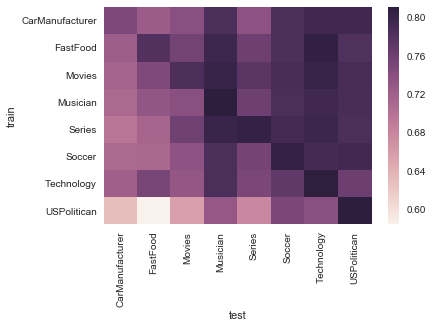

In [124]:
import seaborn as sns
%matplotlib inline

#add the results for the own classifiers
df_results_own_classifier_copy = df_results_own_classifier.copy()
df_results_own_classifier_copy["train"] = df_results_own_classifier_copy["topic"]
df_results_own_classifier_copy["test"] = df_results_own_classifier_copy["topic"]


#calculate f1 scores
df = pd.DataFrame.from_dict(results)
df["f1_score_weighted"] = (df["f1_score_positive"]*df["support_positive"]+df["f1_score_negative"]*df["support_negative"])/(df["support_negative"]+df["support_positive"])
df = pd.concat([df,df_results_own_classifier_copy])
f1_matrix = df.groupby(['train','test'])["f1_score_weighted"].mean().unstack()


display(f1_matrix)

weighted_overall_f1 = ((df["support_negative"]+df["support_positive"])*df["f1_score_weighted"]).sum()/(df["support_negative"]+df["support_positive"]).sum()
print
print("Overall Weighted F1 Score:")
print(weighted_overall_f1)

sns.heatmap(f1_matrix, 
            xticklabels=f1_matrix.columns.values,
            yticklabels=f1_matrix.columns.values)